## 1.Load the beans dataset.

In [1]:
#import tensorflow as tf
import tensorflow.compat.v2 as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
# Enable eager execution
tf.enable_v2_behavior()

In [2]:

%%time
import importlib

def import_or_install(library):
    try:
        importlib.import_module(library)
        print(f"{library} is already installed.")
    except ImportError:
        print(f"{library} is not installed. Installing...")
        !pip install {library}
        print(f"{library} has been successfully installed.")

# Example usage:
libraries_to_check = ["tensorflow_datasets"]

for library in libraries_to_check:
    import_or_install(library)

tensorflow_datasets is already installed.
CPU times: total: 172 ms
Wall time: 657 ms


In [3]:
import tensorflow_datasets as tfds

(bn_train, bn_validation, bn_test),bn_info = tfds.load(

    name = 'beans',

    split = ['train', 'validation', 'test'],

    as_supervised = True,

    with_info = True)

print(bn_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='C:\\Users\\heinz\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        '

In [4]:
# the training dataset has features/image and label/target
for image, label in bn_train.take(1):  # example is (image, label)
  print(image.shape, label)
  

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [5]:
print(bn_info.features["label"].num_classes)
print(bn_info.features["label"].names)

3
['angular_leaf_spot', 'bean_rust', 'healthy']


In [6]:
print(bn_info.features.shape)
print(bn_info.features.np_dtype)
print(bn_info.features['image'].shape)
print(bn_info.features['image'].np_dtype)

{'image': (500, 500, 3), 'label': ()}
{'image': <class 'numpy.uint8'>, 'label': <class 'numpy.int64'>}
(500, 500, 3)
<class 'numpy.uint8'>


In [7]:
import tensorflow as tf
from tensorflow.data import Dataset

# Assuming you have a pre-loaded image dataset `image_dataset`

# Convert dataset to a NumPy array (images and labels)
data_array = tfds.as_numpy(bn_train)

for imgs, labels in data_array:
    print (imgs.shape, labels.shape)
    break

(500, 500, 3) ()


In [8]:

# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)
# the inputs are the image, label and target size
def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label
#apply normalize_image() function to each of image avoid writing a loop
bn_train = bn_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_train = bn_train.cache().shuffle(1000)
bn_train = bn_train.shuffle(bn_info.splits['train'].num_examples)
bn_train = bn_train.batch(batch_size)
bn_train = bn_train.prefetch(tf.data.experimental.AUTOTUNE)


Perform the similar tasks for the validation dataset

In [9]:
bn_validation = bn_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_validation = bn_validation.batch(batch_size)
bn_validation = bn_validation.cache()
bn_validation = bn_validation.prefetch(tf.data.experimental.AUTOTUNE)

bn_test = bn_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_test = bn_test.batch(batch_size)
bn_test = bn_test.cache()
bn_test = bn_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    # since we handle labels only in this funciton, we discard the first parameter that is image
    # we take out one batch that is 32 images and lables
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    # the l_labels is a nest of list , for example [ [1, 0, 2, ...], [2,1, 1,..], ..]
    # return a single list by using list comprehension
    #[1, 0, 2, ..., 2, 1, 1, ..]
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(bn_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(bn_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(bn_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


## Convert TensorFlow Dataset to Numpy Array to Inspect the Pixel Values

In [12]:
import tensorflow as tf
from tensorflow.data import Dataset


# Convert dataset to a NumPy array (images and labels)
image_array = tfds.as_numpy(bn_train)

for img in image_array:
    print (imgs.shape)
    break

(500, 500, 3)


In [13]:
img[0]

array([[[[0.03921569, 0.        , 0.        ],
         [0.04313726, 0.        , 0.        ],
         [0.04313726, 0.00392157, 0.        ],
         ...,
         [0.10588235, 0.04705882, 0.01960784],
         [0.11372549, 0.05490196, 0.02745098],
         [0.12156863, 0.0627451 , 0.03529412]],

        [[0.03921569, 0.        , 0.        ],
         [0.03529412, 0.        , 0.        ],
         [0.03921569, 0.        , 0.        ],
         ...,
         [0.09411765, 0.03529412, 0.00784314],
         [0.10196079, 0.04313726, 0.01568628],
         [0.10980392, 0.05098039, 0.02352941]],

        [[0.0627451 , 0.00784314, 0.00392157],
         [0.04313726, 0.        , 0.        ],
         [0.03921569, 0.        , 0.        ],
         ...,
         [0.09411765, 0.03529412, 0.00784314],
         [0.10196079, 0.04313726, 0.01568628],
         [0.10980392, 0.05098039, 0.02352941]],

        ...,

        [[0.23921569, 0.1254902 , 0.14117648],
         [0.22352941, 0.10980392, 0.1254902 ]

In [14]:
print(f'The maximum value of pixels = {np.amax(img[0])}; the minimum value of pixels ={np.amin(img[0])}' )

The maximum value of pixels = 1.0; the minimum value of pixels =0.0


In [15]:
input_shape =imgs.shape
input_shape

(500, 500, 3)

In [16]:
model = models.Sequential()
# Get the image size using codes instead of using magic number (32,32,3)
input_shape =imgs.shape
print(f'The input shape = {input_shape}')
# The first Convolution layer has 32 filters, with the output has 32 channels. The size of the filter is 3*3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= input_shape))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# The Third Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 2*2
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

The input shape = (500, 500, 3)


C:\Users\heinz\anaconda3\envs\new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 498, 498, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 247, 247, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 121, 121, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 120, 120, 64)        │          16,448 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,768 (284.25 KB)

 Trainable params: 72,768 (284.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Convert  feature matrix from 4D to 2D
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# Add dropout layer
model.add(layers.Dropout(0.2))
# Last layer must have 10 neuron to match the label
model.add(layers.Dense(10))

In [19]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
history = model.fit(bn_train, epochs=20, 
                    validation_data=bn_validation, callbacks=[callback], verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.3557 - loss: 4.7715 - val_accuracy: 0.5038 - val_loss: 1.3188
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.5420 - loss: 1.1366 - val_accuracy: 0.7143 - val_loss: 0.7113
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.6922 - loss: 0.7325 - val_accuracy: 0.7519 - val_loss: 0.5575
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.7545 - loss: 0.6148 - val_accuracy: 0.6992 - val_loss: 0.6052
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.7687 - loss: 0.5616 - val_accuracy: 0.7293 - val_loss: 0.6044
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.8251 - loss: 0.4440 - val_accuracy: 0.7594 - val_loss: 0.6452
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.8624 - loss: 0.3399 - val_accuracy: 0.7068 - val_loss: 0.7121
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.9222 - loss: 0.2141 - val_accuracy: 0.7218 - v

### Evaluate the model

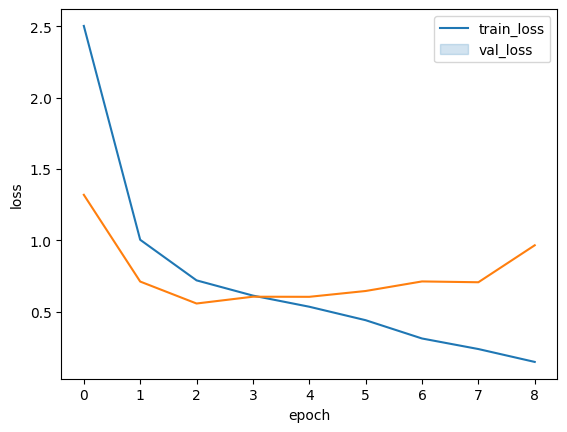

In [22]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])


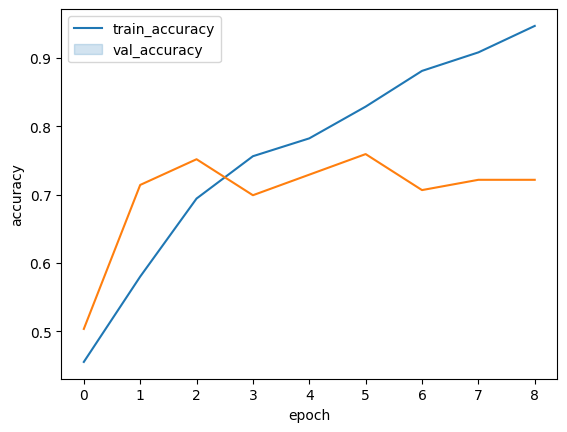

In [23]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [24]:
test_loss, test_acc = model.evaluate(bn_test, verbose=0)
print(f' The test loss ={test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss =0.71 and test accuracy = 0.77


## Is the model underfitiing or overfitting?
The model is overfitting as the training loss keeps decreasing but the validation gets to a point where it starts to increase. This shows that the model is not generalizing well. In addition, this is evident from the divergence between the training and validation accuracy curves.

## 4. Using Data Augmentation

In [25]:
print(tf.__version__)

2.16.1


In [26]:
data_aug = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(image_height, 
                                                              image_width,
                                                              num_channels)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1,width_factor = 0.1 ),
    tf.keras.layers.RandomZoom(height_factor=(0.1, 0.1))
  ]
)

C:\Users\heinz\anaconda3\envs\new_env\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
num_labels = 3

model = tf.keras.Sequential([
  # Data augmentation
  data_aug,
  # Data normalization
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_labels)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 20
history = model.fit(
  bn_train,
  validation_data=bn_validation,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3414 - loss: 1.0996 - val_accuracy: 0.3308 - val_loss: 1.0986
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3429 - loss: 1.0987 - val_accuracy: 0.3383 - val_loss: 1.0986
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3405 - loss: 1.0984 - val_accuracy: 0.3383 - val_loss: 1.0986
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3288 - loss: 1.0987 - val_accuracy: 0.3383 - val_loss: 1.0986
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3336 - loss: 1.0987 - val_accuracy: 0.3383 - val_loss: 1.0986
CPU times: total: 21min 57s
Wall time: 3min 54s


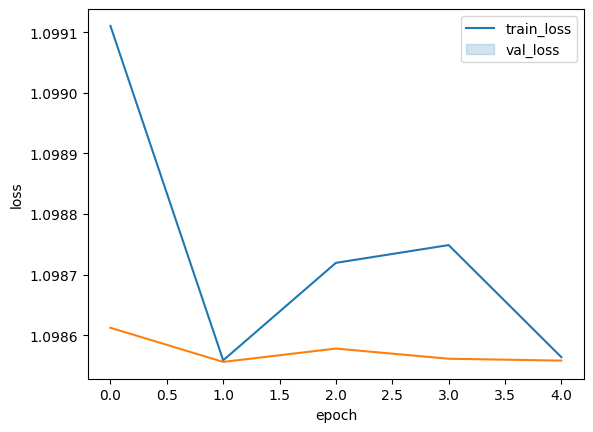

In [33]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

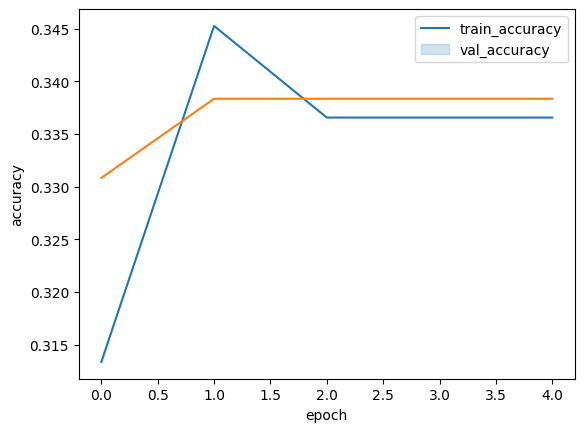

In [34]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [36]:
test_loss, test_acc = model.evaluate(bn_test, verbose=0)
print(f' The test loss ={test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss =1.10 and test accuracy = 0.34


## Does it produce better performance on the test dataset?
No it does not, this can be seen as the test loss is higher than the previous and the test accuracy lower.

## 5. Building CNN network using transfer learning and Tensorflow

In [37]:
# Specify the image size for our dataset
IMG_SHAPE = (image_height, image_width, num_channels)

MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE,
                                               include_top=False, # Remove the fully-connected layer
                                               weights='imagenet') # Pre-training on ImageNet

C:\Users\heinz\anaconda3\envs\new_env\lib\site-packages\keras\src\applications\mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


In [38]:
MobileNetV3Large_model.summary()

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 500, 500, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 250, 250, 16)      │             432 │ rescaling_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 250, 250, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 250, 250, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 250, 250, 16)      │             144 │ activation[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 250, 250, 16)      │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 250, 250, 16)      │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 250, 250, 16)      │             256 │ re_lu[0][0]                │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, 250, 250, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, 250, 250, 16)      │               0 │ activation[0][0],          │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, 250, 250, 64)      │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, 250, 250, 64)      │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 250, 250, 64)      │               

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [39]:
#tf.keras.utils.plot_model(MobileNetV3Large_model, show_shapes=True)

In [40]:
MobileNetV3Large_model.trainable = False

In [41]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [43]:
image_batch, label_batch = next(iter(bn_train))
feature_batch = MobileNetV3Large_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 960)


In [45]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [46]:
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 245760)


In [48]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(f' The size of the predicted value for a given batch = {prediction_batch.shape}')

 The size of the predicted value for a given batch = (32, 5)


In [49]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_aug(inputs)
x = preprocess_input(x)
x = MobileNetV3Large_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [51]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 500, 500, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 500, 500, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobilenetV3large (Functional)        │ (None, 16, 16, 960)         │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │       1,228,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,225,157 (16.12 MB)

 Trainable params: 1,228,805 (4.69 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [53]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [54]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 20
history = model.fit(
  bn_train,
  validation_data=bn_validation,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3231 - loss: 2.0459 - val_accuracy: 0.3308 - val_loss: 1.9975
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3233 - loss: 1.7952 - val_accuracy: 0.4286 - val_loss: 1.0696
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3412 - loss: 1.3806 - val_accuracy: 0.4286 - val_loss: 1.1910
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4040 - loss: 1.3226 - val_accuracy: 0.4211 - val_loss: 1.2703
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3734 - loss: 1.4741 - val_accuracy: 0.3759 - val_loss: 1.2286
CPU times: total: 8min 10s
Wall time: 4min 20s


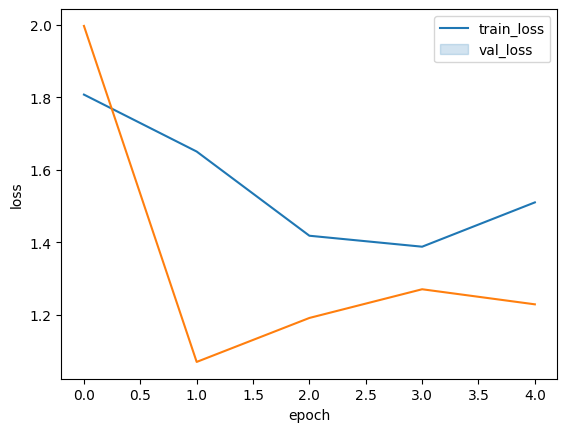

In [55]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

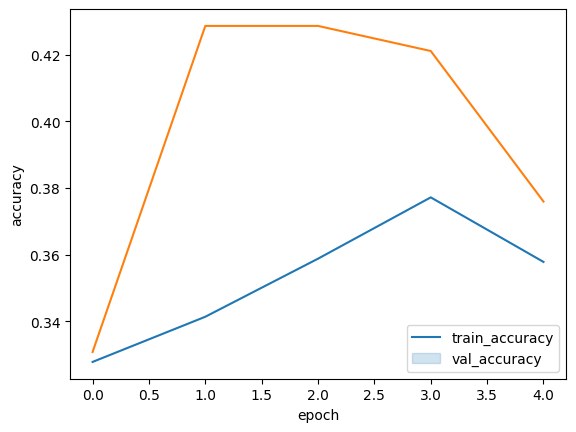

In [56]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
#Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [58]:
test_loss, test_acc = model.evaluate(bn_test, verbose=0)
print(f' The test loss ={test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss =1.23 and test accuracy = 0.34


## Does it produce better performance on the test dataset?
It similarly does not perform well on the test dataset with lower test accuracy and a higher test loss.